In [1]:
## for data query
import cx_Oracle


## Data loading, processing and for more
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

## Visualization
import seaborn as sns
import matplotlib.pyplot as plt
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn import metrics
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, f1_score

#encoding & preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
data = pd.read_excel(r'C:\Users\SamadovIAz\Desktop\snd\machine learning models\fraud_detection\df_last.xlsx')
data

,CUSTOMER,AGE,GENDER,MCC_GROUP,AMOUNT,EXPERIENCE_BY_MONTH,Fraud
0,4JZ9Z87,33,M,AFFILIATES,16.00,60,0
1,3JHUMJD,40,M,AFFILIATES,258.00,82,0
2,1E6R28G,39,F,AFFILIATES,10.00,192,0
3,6BVAVXV,25,F,AFFILIATES,327.00,7,0
4,5HV1XKM,30,M,AFFILIATES,198.00,74,0
...,...,...,...,...,...,...,...
747931,28GM43V,36,M,WHOLESALE SUPPLIERS AND MANUFACTURERS,580.00,153,1
747932,5J3258D,30,M,WHOLESALE SUPPLIERS AND MANUFACTURERS,3.90,67,1
747933,5J3258D,30,M,WHOLESALE SUPPLIERS AND MANUFACTURERS,28.33,67,1
747934,5VJ1EWF,28,M,WHOLESALE SUPPLIERS AND MANUFACTURERS,530.00,43,1


<AxesSubplot:xlabel='EXPERIENCE_BY_MONTH', ylabel='AMOUNT'>

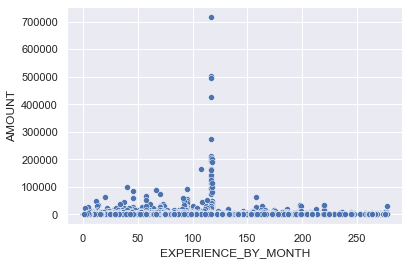

In [3]:
sns.scatterplot(data=data,y='AMOUNT',x='EXPERIENCE_BY_MONTH')

<AxesSubplot:xlabel='AGE', ylabel='AMOUNT'>

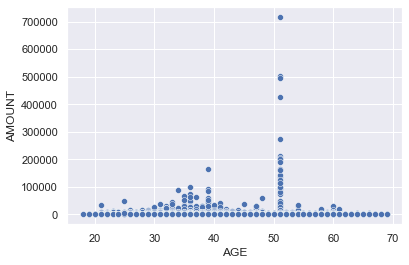

In [4]:
sns.scatterplot(data=data,y='AMOUNT',x='AGE')

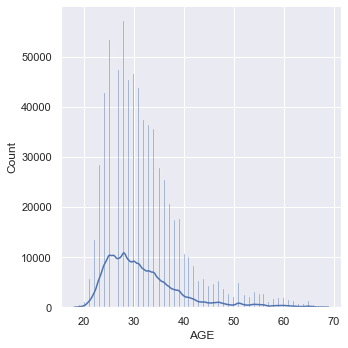

In [5]:
sns.displot(data['AGE'],kde=True)

In [6]:
# sns.displot(data['AMOUNT'],kde=True)

<AxesSubplot:>

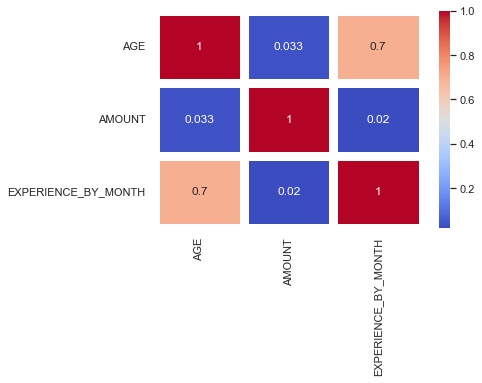

In [7]:
sns.heatmap(data=data[['AGE','AMOUNT','EXPERIENCE_BY_MONTH']].corr(),annot=True,cmap='coolwarm',linecolor='white',linewidth=9)

In [8]:
features=['AGE','GENDER','MCC_GROUP','AMOUNT','EXPERIENCE_BY_MONTH']
target=['Fraud']

In [9]:
X = data[features]
y = data[target]

In [11]:
# If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
# If the skewness is less than -1 or greater than 1, the data are highly skewed

pd.DataFrame(X.skew(numeric_only=True),columns=['Skewness'])

,Skewness
AGE,1.563932
AMOUNT,238.798701
EXPERIENCE_BY_MONTH,1.844095


In [15]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,shuffle=True)

In [16]:
features_to_encode = X_train.columns[X_train.dtypes==object].tolist()  

In [17]:
col_trans = make_column_transformer((OneHotEncoder(drop='first'),features_to_encode),remainder = "passthrough")

In [18]:
rf_classifier = RandomForestClassifier (
                                          min_samples_leaf=50,
                                          n_estimators=150,
                                          bootstrap=True,
                                          oob_score=True,
                                          n_jobs=-1,
                                          random_state=47,
                                          max_features='sqrt'
                                       )

In [19]:
pipe = make_pipeline(col_trans, rf_classifier)

In [20]:
pipe.fit(X_train,np.ravel(y_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['GENDER', 'MCC_GROUP'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(min_samples_leaf=50, n_estimators=150,
                                        n_jobs=-1, oob_score=True,
                                        random_state=47))])

In [21]:
y_pred = pipe.predict(X_test)

In [22]:
accuracy_score(y_test, y_pred)
print(f"The accuracy of the model is {round(accuracy_score(y_test,y_pred),3)*100} %")

The accuracy of the model is 99.0 %


In [23]:
train_probs = pipe.predict_proba(X_train)[:,1] 
probs = pipe.predict_proba(X_test)[:, 1]
train_predictions = pipe.predict(X_train)

In [24]:
print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))

Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    217958
           1       0.90      0.74      0.81      6423

    accuracy                           0.99    224381
   macro avg       0.95      0.87      0.90    224381
weighted avg       0.99      0.99      0.99    224381



In [25]:
print(f'Train ROC AUC Score: { roc_auc_score(y_train, train_probs) }')
print(f'Test ROC AUC  Score: { roc_auc_score(y_test, probs) }')

Train ROC AUC Score: 0.9977980029702094
Test ROC AUC  Score: 0.9974972353077315


In [26]:
# def evaluate_model(y_pred, probs,train_predictions, train_probs):
#     baseline = {}
#     baseline['recall']=recall_score(y_test,
#                     [1 for _ in range(len(y_test))])
#     baseline['precision'] = precision_score(y_test,
#                     [1 for _ in range(len(y_test))])
#     baseline['roc'] = 0.5
#     results = {}
#     results['recall'] = recall_score(y_test, y_pred)
#     results['precision'] = precision_score(y_test, y_pred)
#     results['roc'] = roc_auc_score(y_test, probs)
#     train_results = {}
#     train_results['recall'] = recall_score(y_train,       train_predictions)
#     train_results['precision'] = precision_score(y_train, train_predictions)
#     train_results['roc'] = roc_auc_score(y_train, train_probs)
# #     for metric in ['recall', 'precision', 'roc']:  
# #           print(f'{metric.capitalize()} 
# #                  Baseline: {round(baseline[metric], 2)} 
# #                  Test: {round(results[metric], 2)} 
# #                  Train: {round(train_results[metric], 2)}')
#      # Calculate false positive rates and true positive rates
#     base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
#     model_fpr, model_tpr, _ = roc_curve(y_test, probs)
#     plt.figure(figsize = (8, 6))
#     plt.rcParams['font.size'] = 16
#     # Plot both curves
#     plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
#     plt.plot(model_fpr, model_tpr, 'r', label = 'model')
#     plt.legend();
#     plt.xlabel('False Positive Rate');
#     plt.ylabel('True Positive Rate'); plt.title('ROC Curves');
#     plt.show();
# evaluate_model(y_pred,probs,train_predictions,train_probs)


In [27]:
# import itertools
# def plot_confusion_matrix(cm, classes, normalize = False,
#                           title='Confusion matrix',
#                           cmap=plt.cm.Greens): # can change color 
#     plt.figure(figsize = (10, 10))
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title, size = 24)
#     plt.colorbar(aspect=4)
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45, size = 14)
#     plt.yticks(tick_marks, classes, size = 14)
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     # Label the plot
#     for i, j in itertools.product(range(cm.shape[0]),   range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), 
#                  fontsize = 20,
#                  horizontalalignment="center",
#                  color="white" if cm[i, j] > thresh else "black")
#         plt.grid(None)
#         plt.tight_layout()
#         plt.ylabel('True label', size = 18)
#         plt.xlabel('Predicted label', size = 18)

# # Let's plot it out
# cm = confusion_matrix(y_test, y_pred)
# plot_confusion_matrix(cm, classes = ['0 - Stay', '1 - Exit'],
#                       title = 'Exit_status Confusion Matrix')

In [28]:
# print(rf_classifier.feature_importances_)
# print(f" There are {len(rf_classifier.feature_importances_)} features in total")

In [29]:
def encode_and_bind(original_dataframe, features_to_encode):
    dummies = pd.get_dummies(original_dataframe[features_to_encode])
    res = pd.concat([dummies, original_dataframe], axis=1)
    res = res.drop(features_to_encode, axis=1)
    return(res)
X_train_encoded = encode_and_bind(X_train, features_to_encode)

In [30]:
# feature_importances = list(zip(X_train_encoded, rf_classifier.feature_importances_))
# # Then sort the feature importances by most important first
# feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# # Print out the feature and importances
# [print('Feature: {:35} Importance: {}'.format(*pair)) for pair in feature_importances_ranked];

In [31]:
# feature_names_25 = [i[0] for i in feature_importances_ranked[:25]]
# y_ticks = np.arange(0, len(feature_names_25))
# x_axis = [i[1] for i in feature_importances_ranked[:25]]
# plt.figure(figsize = (10, 14))
# plt.barh(feature_names_25, x_axis)   #horizontal barplot
# plt.title('Random Forest Feature Importance (Top 25)',
#           fontdict= {'fontname':'Comic Sans MS','fontsize' : 20})
# plt.xlabel('Features',fontdict= {'fontsize' : 16})
# plt.show()

In [32]:
# from pprint import pprint
# print('Parameters currently in use:\n')
# pprint(rf_classifier.get_params())

In [35]:
deploy = pd.read_excel(r'C:\Users\SamadovIAz\Desktop\snd\machine learning models\fraud_detection\deploy_data.xlsx')

In [36]:
test = deploy.copy()
test_withoutID = test.copy().drop('CUSTOMER', axis = 1)
final_y = pipe.predict(test_withoutID)
#pipe model only takes in dataframe without ID column.
final_report = test
final_report['Fraud_prediction'] = final_y
final_report = final_report.loc[:,['CUSTOMER','Fraud_prediction']]
# Replace 1-0 with Yes-No to make it interpretable
# final_report= final_report.replace(1, 'Yes')
# final_report= final_report.replace(0, 'No')

In [37]:
final_report

,CUSTOMER,Fraud_prediction
0,0Y52MRJ,0
1,5UNXDMB,0
2,6AAWL0A,0
3,6FE9BGD,0
4,166KB3F,0
...,...,...
208780,63003KY,0
208781,4SKPEVY,0
208782,5LE54Q8,0
208783,5FV3N60,0


In [52]:
pwd

'C:\\Users\\SamadovIAz\\Desktop\\snd\\machine learning models\\fraud_detection'

In [38]:
final_report.to_excel('deploy_prediction.xlsx', engine='xlsxwriter')

In [39]:
# from sklearn.model_selection import RandomizedSearchCV
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
# max_features = ['auto', 'log2']  # Number of features to consider at every split
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]   # Maximum number of levels in tree
# max_depth.append(None)
# min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
# min_samples_leaf = [1, 4, 10]    # Minimum number of samples required at each leaf node
# bootstrap = [True, False]       # Method of selecting samples for training each tree
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
#                'bootstrap': bootstrap}

<!-- # Create base model to tune
rf = RandomForestClassifier(oob_score=True)
# Create random search model and fit the data
rf_random =  RandomizedSearchCV(estimator = rf,
                                param_distributions = random_grid,
                                n_iter = 100, cv = 3,
                                verbose=2, random_state=47, 
                                scoring='roc_auc')
rf_random.fit(X_train_encoded, np.ravel(y_train))
rf_random.best_params_ -->

In [40]:
# features=pd.get_dummies(X,drop_first=True)
# features

# ohe = OneHotEncoder(sparse_output=False)
# ohe.fit(X_train[['GENDER','MCC_GROUP']])

# def get_ohe(df):
#     temp_df = pd.DataFrame(data=ohe.transform(df[['GENDER','MCC_GROUP']]), columns=ohe.get_feature_names_out())
#     df.drop(columns=['GENDER','MCC_GROUP'], axis=1, inplace=True)
#     df = pd.concat([df.reset_index(drop=True), temp_df], axis=1)
#     return df

# X_train = get_ohe(X_train)
# X_test = get_ohe(X_test)

In [41]:
# sm = SMOTE(random_state=42)
# X_res, y_res = sm.fit_resample(X , y)
# y_res = pd.DataFrame(y_res)

In [42]:
# scaler = MinMaxScaler()
# X_res = scaler.fit_transform(X_res)
# y_res = scaler.fit_transform(y_res)

In [43]:
# pd.DataFrame(X_res)
# features.columns

In [44]:
# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import train_test_split
# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# models

In [45]:
# %%time
# knn = KNeighborsClassifier(n_neighbors=5,p=1)

# knn.fit(X_train,np.ravel(y_train))
# y_pred = knn.predict(X_test)


# print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
# print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))


In [46]:
# %%time
# rf_clf = RandomForestClassifier(n_estimators=100,
#                                 max_depth=8,
#                                 random_state=42,
#                                 verbose=0,
#                                 class_weight="balanced")

# rf_clf.fit(X_train,np.ravel(y_train))
# y_pred = rf_clf.predict(X_test)

# print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
# print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))


In [47]:
# pd.Series(rf_clf.feature_importances_,index=pd.DataFrame(X_train).columns).nlargest(3).plot(kind='barh')

In [48]:
# deploy = pd.read_excel(r'C:\Users\SamadovIAz\Desktop\snd\py\deploy_data.xlsx')
# deploy

In [49]:
# deploy_d=pd.get_dummies(deploy[['AGE','GENDER','MCC_GROUP','AMOUNT','EXPERIENCE_BY_MONTH']],drop_first=True)
# deploy_d

In [50]:
# deploy_d=get_ohe(deploy_d[features])
# deploy_d

In [51]:
# deploy_p = rf_clf.predict(deploy_d)
# deploy_p